# CNN

Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import os
import shutil

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature

import numpy as np
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import load_model

from mlflow.models.signature import infer_signature



### Initialice mlflow to track the model training

In [31]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8000")
client = MlflowClient()

# Load dataset

In [2]:
data_dir = r"C:\Users\apx180\Documents\CIClocal\tesis\air_pollution_data\traffic_images\MER"
data_dir = r"C:\Users\valer\Documents\CIC\doctorado\air_pollution\traffic_flow\vector\traffic_images_relative0\MER"

In [ ]:
"""
for root, dirs, files in os.walk(data_dir):
	for file in files:
		file_path = os.path.join(root, file)
		if file_path.endswith('.png'):

			file_path = os.path.join(root, file)
			new_path = os.path.join(data_dir, file)
			try:
				shutil.move(file_path, new_path)
				#print(f"Moved: {file_path} -> {new_path}")
			except Exception as e:
				print(f"Failed to move {file_path}: {e}")
"""


In [2]:
#"""
df_pol = pd.read_csv(r"C:\Users\valer\Documents\CIC\doctorado\air_pollution\preprocessing_airpollution_data\datos_por_estacion_feb_dic_2024\MER.csv")
df_pol.dropna(subset=['O3'], inplace=True)
df_pol = df_pol[(df_pol[["O3"]] >= 0).all(axis=1)] # Filter rows with no negative values in numeric columns
# O3 ranges for ICA classification
labels = ['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy', 'Hazardous']  
bins = [0, 58, 90, 135, 175, 300] 
data_dir = r"C:\Users\valer\Documents\CIC\doctorado\air_pollution\traffic_flow\vector\traffic_images_relative0\MER"
data_dir2 = r"C:\Users\valer\Documents\CIC\doctorado\air_pollution\traffic_flow\vector\traffic_images_relative0\MER2"
images = os.listdir(data_dir2)
images = [img for img in images if img.endswith(".png")]
pollutant = "O3"
for img in images:
	day = img[4:6]
	month = img[7:9]
	year = img[10:14]
	hour =img[15:17]
	date = year + "/" + month + "/" + day + " " +hour + ":00"
	df_sec = df_pol[df_pol["date"]== date]
	pollutant_value = df_sec.iloc[0][pollutant]
	file_path = os.path.join(data_dir2, img)
	try:
		if pollutant_value <= bins[1]:
			new_path = os.path.join(data_dir, labels[0])
			shutil.move(file_path, new_path)
		elif pollutant_value <= bins[2]:
			new_path = os.path.join(data_dir, labels[1])
			shutil.move(file_path, new_path)
		elif pollutant_value <= bins[3]:
			new_path = os.path.join(data_dir, labels[2])
			shutil.move(file_path, new_path)
		elif pollutant_value <= bins[4]:
			new_path = os.path.join(data_dir, labels[3])
			shutil.move(file_path, new_path)
		elif pollutant_value > bins[4]:
			new_path = os.path.join(data_dir, labels[4])
			shutil.move(file_path, new_path)
	except Exception as e:
		print(f"Failed to move {file_path}: {e}")
#"""

In [8]:
from PIL import Image
im = Image.open(r"C:\Users\valer\Documents\CIC\doctorado\air_pollution\traffic_flow\vector\traffic_images\MER\Good\MER_01_03_2024_00_04_42.png")
#im.show()

In [4]:
BATCH_SIZE = 24
IMG_SIZE = (250, 250)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
															validation_split=0.2,
															subset="training",
															seed=42,
															batch_size=BATCH_SIZE,
															image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
															validation_split=0.2,
															subset="validation",
															seed=42,
															batch_size=BATCH_SIZE,
															image_size=IMG_SIZE)

class_names = train_dataset.class_names



Found 17541 files belonging to 3 classes.
Using 14033 files for training.
Found 17541 files belonging to 3 classes.
Using 3508 files for validation.


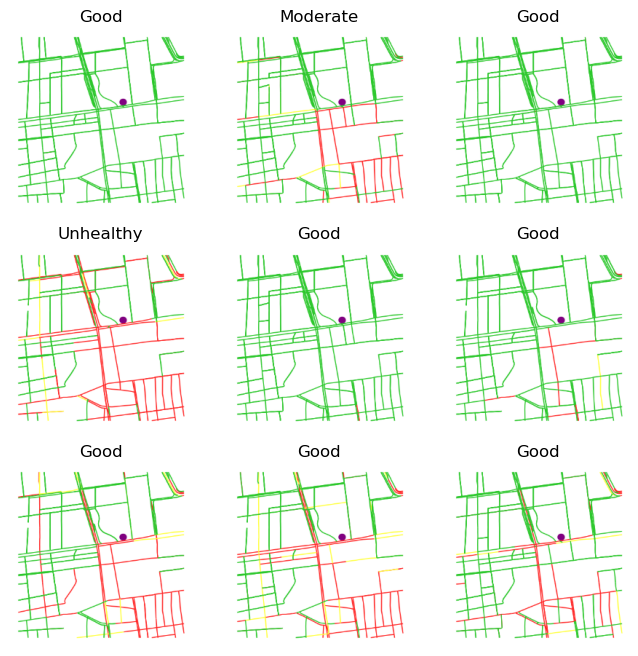

In [34]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(2):
	for i in range(9):
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

### Estructura de la CNN
Aquí se crea la estructura de la parte de **convolución** de la red, se definen las capas que utilizará. Comúnmente se van colocando de forma secuencial capas Conv2D y MaxPooling2D.


### Juntando y entrenando el modelo

In [39]:
# Define global precision and recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
@tf.keras.utils.register_keras_serializable()
def f1score(y_true, y_pred):
	# Convert predictions to labels
	y_pred = tf.argmax(y_pred, axis=1)
	y_true = tf.cast(y_true, tf.int32)

	# Update precision and recall
	precision_metric.update_state(y_true, y_pred)
	recall_metric.update_state(y_true, y_pred)

	# Compute precision and recall values
	precision = precision_metric.result()
	recall = recall_metric.result()

	# F1 score
	f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
	return f1

from tensorflow.keras import backend as K

def balancedaccuracy(y_true, y_pred):
    # Convertir predicciones a etiquetas (si `from_logits=True`, usar `tf.nn.softmax(y_pred)`)
    y_pred_labels = tf.argmax(y_pred, axis=1)

    # Calcular la matriz de confusión
    cm = tf.math.confusion_matrix(y_true, y_pred_labels, dtype=tf.float32)

    # Calcular la sensibilidad (recall) por clase: TP / (TP + FN)
    recall_per_class = tf.linalg.diag_part(cm) / (tf.reduce_sum(cm, axis=1) + K.epsilon())

    # Calcular Balanced Accuracy como el promedio del recall por clase
    balanced_acc = tf.reduce_mean(recall_per_class)

    return balanced_acc

In [24]:
def uploadFirstModel(model_dir, model_name,station, metrics_results, target, EXPERIMENT_NAME, FirstModel):

	loaded_model = load_model(model_dir)
	mlflow.set_experiment(EXPERIMENT_NAME)
	# Start an MLflow run
	with mlflow.start_run() as run:
		run_id = run.info.run_id
		
		# Log scaler as an artifact
		#mlflow.log_artifact(dir_scaler, artifact_path="artifacts")

		mlflow.log_dict({"stations": [station], "target":target, "hidden_layers": "10"}, "details.json")
		# Log the metrics
		for metric_name, value in metrics_results.items():
			mlflow.log_metric(metric_name, value)

		# Set a tag that we can use to remind ourselves what this run was for
		info =  f"CNN {target}-{station}"
		mlflow.set_tag("Model Info",info)
		
		# Log the model
		model_info = mlflow.keras.log_model(loaded_model,
			artifact_path=f"{station} station for {target} classification",
			registered_model_name=model_name
		)
		#
		model_uri = f"runs:/{run_id}/{station} station model for O3".format(run.info.run_id)
		mv = client.create_model_version(model_name, model_uri, run.info.run_id)

		# Asignar un alias al modelo
		client.set_registered_model_alias(model_name, "validation_status", mv.version)
		# Asignar un tag al modelo registrado
		client.set_model_version_tag(
			name=model_name,
			version= '1',
			key = "historicalData"
		)

	if FirstModel == False:
		client = MlflowClient()
		#model_name = "O3-mer_1hr_forecast_model"
		best_model_alias = "champion"
		best_model_info = client.get_model_version_by_alias(model_name, best_model_alias)
		best_model_version = best_model_info.version
		best_model_run_id = best_model_info.run_id
		# Acceder a las métricas del mejor modelo
		best_metrics = client.get_run(best_model_run_id).data.metrics
		# Comparar las métricas del modelo actual con el mejor modelo hasta el momento
		if metrics_results["F1_score"] > best_metrics["F1_score"]:
			#Registra el nuevo modelo como el mejor
			client.set_registered_model_alias(model_name, best_model_alias, mv.version)
			client.delete_registered_model_alias(model_name, "validation_status") 
			client.set_registered_model_alias(model_name, "old_champion", best_model_version)
		else:
			print("The model performance doesn;t improve")
	return

In [10]:
#def implementExperimentMlflow(model_dir,model_name,station, metrics_results):
def implementExperimentMlflow(model_dir, model_name,station, metrics_results, target, EXPERIMENT_NAME):

	loaded_model = load_model(model_dir)
	mlflow.set_experiment(EXPERIMENT_NAME)

	#params = model.get_params()
	# Start an MLflow run
	with mlflow.start_run() as run:
		# Log the hyperparameters
		#mlflow.log_params(params)
		run_id = run.info.run_id

		# Loguear el archivo JSON como un artifact en MLflow
		#mlflow.log_artifact(f'../Scalers/{station}_scaler_O3.pkl', artifact_path="artifacts")

		# Log the loss metric
		#for metric_name, value in metrics_results.items():
		#    mlflow.log_metric(metric_name, value)
		
		# Set a tag that we can use to remind ourselves what this run was for
		info =  f"CNN for {station}-ICA classification, with the {station}-station data"
		mlflow.set_tag("Training Info",info)

		# Infer the model signature (la forma de la entrada del modelo)
		#the training dataset with target column omitted) and valid model output 
		#signature = infer_signature(Xtrain, model.predict(Xtrain))
		# Check the shape of the inputs and outputs
		for images, labels in train_dataset.take(1):
			pass
		tensor_shapes = {"input":images[0].shape ,"output": predictions[0].shape}
		print(tensor_shapes)


		model_name = f"O3-ICA_classification_model"
		
		# Log the model
		model_info = mlflow.keras.log_model(model,
			artifact_path=f"model for O3 ICA classification",
			registered_model_name=model_name
		)

		#
		model_uri = f"runs:/{run_id}/{station} station model for O3 ".format(run.info.run_id)
		mv = client.create_model_version(model_name, model_uri, run.info.run_id)

		# Asignar un alias al modelo
		client.set_registered_model_alias(model_name, "validation_status", mv.version)
		# Asignar un tag al modelo registrado
		client.set_model_version_tag(
			name=model_name,
			version= '1',
			key = "historicalData"
		)

		#Verificar cual es el mejor modelo y si es el mejor lo regristra
		model_name = f"O3-{station}_ICA_classification_model"
		best_model_alias = "champion"
		"""
		best_model_info = client.get_model_version_by_alias(model_name, best_model_alias)
		best_model_version = best_model_info.version
		best_model_run_id = best_model_info.run_id
		# Acceder a las métricas del mejor modelo
		best_metrics = client.get_run(best_model_run_id).data.metrics
		# Comparar las métricas del modelo actual con el mejor modelo hasta el momento
		if metrics_results["r2adjusted"] > best_metrics["r2adjusted"] and metrics_results["rmse"] < best_metrics["rmse"]:
			#Registra el nuevo modelo como el mejor
			client.set_registered_model_alias(model_name, best_model_alias, mv.version)
			client.delete_registered_model_alias(model_name, "validation_status") 
			client.set_registered_model_alias(model_name, "old_champion", best_model_version)
		else:
			print("The performance didn't improve")
		"""


In [ ]:

def train(Cmodel, Xtrain, Ytrain):
	
	param_grid = {
		'n_estimators': range(50,500,10),
		'max_depth': range(4,15,3)
	}
	

	#rand_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='r2',return_train_score=True)
	
	Cmodel.fit(validation_dataset)

	return rand_search.best_estimator_

In [40]:
def metrics(predictions):
	# Obtener las clases predichas
	predicted_classes = np.argmax(predictions, axis=1)

	# Convertir índices de clase a nombres de clase
	predicted_class_names = [class_names[i] for i in predicted_classes]
	true_class_names = [class_names[i] for i in labels.numpy()]

	# Obtener las etiquetas verdaderas
	true_labels = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
	true_class_names = [class_names[i] for i in true_labels]

	
	accuracy = accuracy_score(true_labels, predicted_classes)
	return {'accuracy':accuracy}


In [15]:
import tensorflow as tf
print(tf.__version__)


2.14.0


In [41]:
STATION = "MER"
RUTA_MODELOS = r"C:\Users\valer\Documents\CIC\doctorado\air_pollution_data\Models"
POLLUTANT = "O3"
EXPERIMENT_NAME = f"CNN_{POLLUTANT}_ICA_Classification"

num_classes = 3
model_name = f'{STATION}_{POLLUTANT}_best_model.h5'
model_path = os.path.join(RUTA_MODELOS, POLLUTANT)
model_path = os.path.join(model_path, model_name)

model_mlflow_name = f"O3_{STATION}_ICA_class_CNN"

In [ ]:

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
	filepath=   model_path,  # Ruta donde se guarda el modelo
	monitor='val_f1score',    # Métrica a monitorear
	save_best_only=True,       # Solo guarda si la métrica mejora
	mode='max',                # 'max' porque queremos maximizar la accuracy
	verbose=1                  # Muestra mensajes sobre el guardado
)

tf.keras.callbacks.EarlyStopping(
	monitor="val_loss",
	min_delta=0,
	patience=0,
	verbose=0,
	mode="auto",
	baseline=None,
	restore_best_weights=False,
	start_from_epoch=0,
)


model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  tf.keras.layers.Conv2D(64,3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  tf.keras.layers.Conv2D(32,3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='relu'),
  Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


input_shape = (4, 28, 28, 3)
>>> x = tf.random.normal(input_shape)
>>> y = tf.keras.layers.Conv2D(
... 2, 3, activation='relu', input_shape=input_shape[1:])(x)
>>> print(y.shape)
(4, 26, 26, 2)
>>> # With `dilation_rate` as 2.
>>> input_shape = (4, 28, 28, 3)
>>> x = tf.random.normal(input_shape)
>>> y = tf.keras.layers.Conv2D(
...     2, 3,
...     activation='relu',
...     dilation_rate=2,
...     input_shape=input_shape[1:])(x)
>>> print(y.shape)
(4, 24, 24, 2)
>>> # With `padding` as "same".
>>> input_shape = (4, 28, 28, 3)
>>> x = tf.random.normal(input_shape)
>>> y = tf.keras.layers.Conv2D(
... 2, 3, activation='relu', padding="same", input_shape=input_shape[1:])(x)
>>> print(y.shape)
(4, 28, 28, 2)
>>> # With extended batch shape [4, 7]:
>>> input_shape = (4, 7, 28, 28, 3)
>>> x = tf.random.normal(input_shape)
>>> y = tf.keras.layers.Conv2D(
... 2, 3, activation='relu', input_shape=input_shape[2:])(x)
>>> print(y.shape)
(4, 7, 26, 26, 2)


model.compile(optimizer='adam',
			loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
			metrics=[f1score, balancedaccuracy])
epochs = 1
station = "MER"
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,
	callbacks=[checkpoint_callback] )


585/585 [==============================] - ETA: 0s - loss: 0.4778 - f1score: 0.0113 - balancedaccuracy: 0.3819
Epoch 1: val_f1score improved from -inf to 0.00204, saving model to C:\Users\valer\Documents\CIC\doctorado\air_pollution_data\Models\O3\MER_O3_best_model.h5


c:\Users\valer\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


585/585 [==============================] - 3074s 5s/step - loss: 0.4778 - f1score: 0.0113 - balancedaccuracy: 0.3819 - val_loss: 0.4080 - val_f1score: 0.0020 - val_balancedaccuracy: 0.3753


In [43]:
predictions = model.predict(validation_dataset)
metrics_results = metrics(predictions)
print(metrics_results)
stations_list = ["MER"]
#implementExperimentMlflow(model,f"CNN_O3_ICA_Class",stations_list, metrics_results)

147/147 [==============================] - 116s 790ms/step
{'accuracy': 0.8112884834663626}


In [28]:
predictions

array([[0.6733137 , 0.20501456, 0.10783225, 0.0138395 ],
       [0.7331514 , 0.1799449 , 0.07954436, 0.0073593 ],
       [0.6739321 , 0.20461117, 0.10780974, 0.01364694],
       ...,
       [0.64803845, 0.21511756, 0.11922505, 0.017619  ],
       [0.65423876, 0.21287978, 0.11579145, 0.01709   ],
       [0.73400944, 0.18050085, 0.0780783 , 0.00741132]], dtype=float32)

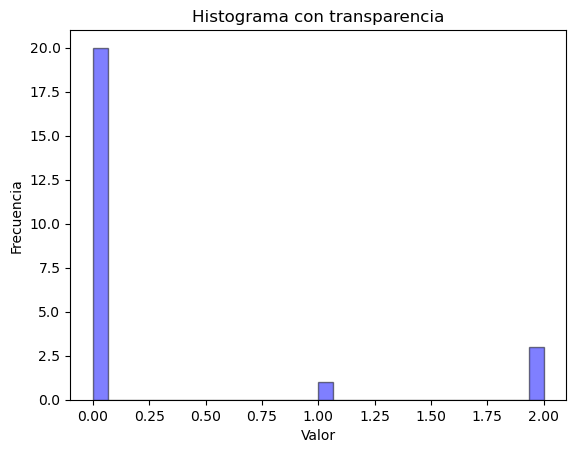

In [44]:
#plt.hist(predicted_classes, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.hist(labels, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma con transparencia')
plt.show()

In [21]:
if not mlflow.get_experiment_by_name(EXPERIMENT_NAME):
	mlflow.create_experiment(name=EXPERIMENT_NAME)
	if not os.path.exists(model_path):
		os.mkdir(model_path)

#experiments = client.search_experiments(filter_string=f"name = '{EXPERIMENT_NAME}'")
#experiment_id = experiments[0].experiment_id
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = experiment.experiment_id

runs = mlflow.search_runs(experiment_ids=[experiment_id])

if runs.empty:
	FirstModel =True
else:
	FirstModel =False

uploadFirstModel(model_path, model_name,station, metrics_results, POLLUTANT, EXPERIMENT_NAME, FirstModel)


2025/02/04 13:51:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


TypeError: cannot pickle 'SymbolicTensor' object

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def build_model(num_hidden_layers, units_per_layer, input_shape, output_units):
	model = Sequential()
	#model.add(Dense(units=units_per_layer, activation='relu', input_shape=input_shape))
	model.add(Conv2D(32, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	# Dynamically add hidden layers
	for _ in range(num_hidden_layers):
		model.add(Dense(units=units_per_layer, activation='relu'))
		r = random(1,3)
		model.add(Dropout(probability))
	
	# Output layer
	model.add(Dense(output_units, activation='softmax'))  # Assuming a classification problem
	return model

# Example usage
input_shape = (32,)  # Feature size of input
output_units = 10  # Number of classes
num_hidden_layers = 3  # Test 3 hidden layers
units_per_layer = 64  # Each hidden layer has 64 units

model = build_model(num_hidden_layers, units_per_layer, input_shape, output_units)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

In [ ]:
#traemos datos 
df = load_dataset(station)

#separamos datos
Xtrain, Xtest, Ytrain, Ytest = prepare_data(df)

#Creamos modelo random forest
rfmodel = RandomForestClassifier()

#Obtenemos el mejor estimador
best_rf = train(rfmodel, Xtrain, Ytrain)

YPred = best_rf.predict(Xtest)

metrics_results = metrics(Xtest, Ytest, YPred, printData=False)

print(metrics_results)

accuracy = accuracy_score(Ytest, YPred)
print("Accuracy:", accuracy)

#Registramos el modelo
implementExperimentMlflow(best_rf,f"RandomForest_O3_24_Classif_{station}",station, metrics_results, Xtrain)


### Evaluar el modelo

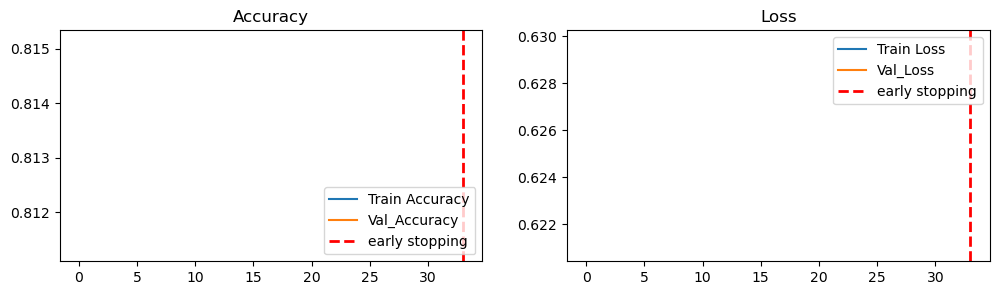

In [19]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val_Accuracy')
plt.axvline(x=33, color='red', linestyle='--', linewidth=2, label='early stopping')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val_Loss')
plt.title('Loss')
plt.axvline(x=33, color='red', linestyle='--', linewidth=2, label='early stopping')
plt.legend(loc='upper right')

plt.show()

In [12]:
predictions = model.predict(validation_dataset)

60/60 [==============================] - 5s 82ms/step


In [13]:
predictions

array([[8.0770910e-01, 1.8530056e-01, 6.9903992e-03],
       [1.9596671e-01, 5.5996221e-01, 2.4407107e-01],
       [9.9687153e-01, 3.0914641e-03, 3.7131616e-05],
       ...,
       [9.8053437e-01, 1.9071272e-02, 3.9436700e-04],
       [9.9681538e-01, 3.1428933e-03, 4.1664789e-05],
       [9.2607075e-01, 6.8832546e-02, 5.0967708e-03]], dtype=float32)

In [44]:
# Obtener las clases predichas
predicted_classes = np.argmax(predictions, axis=1)

# Convertir índices de clase a nombres de clase
predicted_class_names = [class_names[i] for i in predicted_classes]
true_class_names = [class_names[i] for i in labels.numpy()]

In [30]:
predicted_classes

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [16]:
predicted_class_names

['Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Moderate',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',


In [45]:

# Obtener las etiquetas verdaderas
true_labels = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
true_class_names = [class_names[i] for i in true_labels]
print(true_labels)
print(true_class_names)

[1 0 1 ... 2 1 0]
['Moderate', 'Good', 'Moderate', 'Good', 'Good', 'Moderate', 'Moderate', 'Moderate', 'Good', 'Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Unhealthy', 'Good', 'Unhealthy', 'Moderate', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Moderate', 'Unhealthy', 'Good', 'Moderate', 'Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Moderat

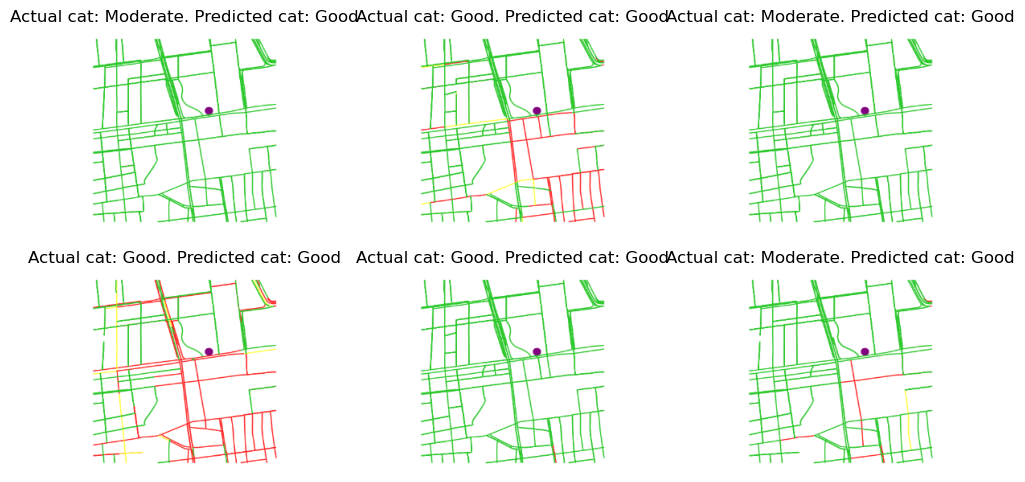

In [46]:
# Mostrar algunas imágenes junto con sus predicciones y etiquetas reales
plt.figure(figsize=(12, 12))
for i in range(6):
	plt.subplot(4, 3, i + 1)
	plt.imshow(images[i].numpy().astype("uint8"))
	plt.title(f'Actual cat: {true_class_names[i]}. Predicted cat: {predicted_class_names[i]}')
	plt.axis('off')

plt.show()

In [47]:
# Calcular la precisión
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Precisión en el conjunto de validación: {accuracy:.4f}')


Precisión en el conjunto de validación: 0.8113


In [49]:
# Obtener las etiquetas verdaderas y las predicciones
y_true = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
#y_pred = np.argmax(model.predict(validation_dataset), axis=1)
y_pred = np.argmax(predictions, axis=1)


In [21]:
y_true

array([0, 2, 0, ..., 0, 0, 0])

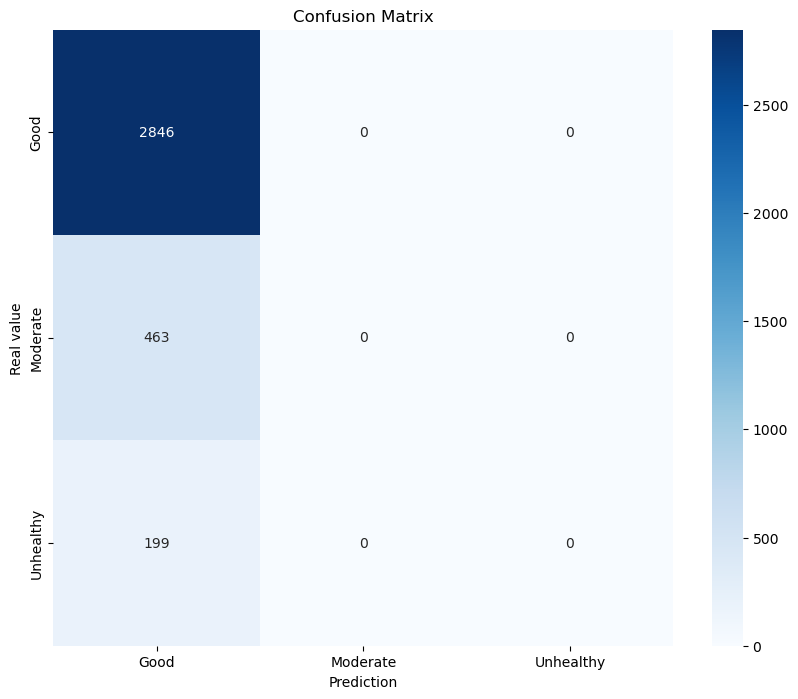

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Real value')
plt.title('Confusion Matrix')
plt.show()


# Sequential CRNN

### Clasification

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
	Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
	MaxPooling2D(pool_size=(2, 2)),
	Conv2D(64, (3, 3), activation='relu'),
	MaxPooling2D(pool_size=(2, 2)),
	Flatten(),
	Dense(128, activation='relu'),
	Dense(1, activation='sigmoid')  # Para clasificación binaria; usa softmax para multicategoría
])


### Regression

In [ ]:
model = Sequential([
	Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
	MaxPooling2D(pool_size=(2, 2)),
	Flatten(),
	Dense(128, activation='relu'),
	Dense(1)  # Para regresión, salida sin activación
])


# Multi input

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

# Entrada para las imágenes
image_input = Input(shape=(altura, ancho, canales), name="image_input")
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Entrada para los datos adicionales (sensor, fecha, hora)
sensor_input = Input(shape=(n_features_sensores,), name="sensor_input")
y = Dense(64, activation='relu')(sensor_input)

# Combina las salidas de las dos ramas (imagen y datos tabulares)
combined = Concatenate()([x, y])

# Capa de salida (para regresión o clasificación)
output = Dense(1, activation='linear')(combined)  # Para regresión (cambiar a 'softmax' para clasificación)

# Crear el modelo
model = Model(inputs=[image_input, sensor_input], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [ ]:
import torch
import torch.nn as nn

class CNNJetTagger(nn.Module):
	def __init__(self):
		super(CNNJetTagger, self).__init__()
		self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
		self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
		self.pool = nn.MaxPool2d(kernel_size=(2, 2))
		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(64 * (num_bins // 4) * (num_bins // 4), 128)
		self.fc2 = nn.Linear(128, 1)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.pool(torch.relu(self.conv1(x)))
		x = self.pool(torch.relu(self.conv2(x)))
		x = self.flatten(x)
		x = torch.relu(self.fc1(x))
		x = self.sigmoid(self.fc2(x))
		return x
	
# Creating a CNN class
class ConvNeuralNet(nn.Module):
#  Determine what layers and their order in CNN object 
	def __init__(self, num_classes):
		super(ConvNeuralNet, self).__init__()
		self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
		self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
		self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
		
		self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
		self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
		self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
		
		self.fc1 = nn.Linear(1600, 128)
		self.relu1 = nn.ReLU()
		self.fc2 = nn.Linear(128, num_classes)
	
	# Progresses data across layers    
	def forward(self, x):
		out = self.conv_layer1(x)
		out = self.conv_layer2(out)
		out = self.max_pool1(out)
		
		out = self.conv_layer3(out)
		out = self.conv_layer4(out)
		out = self.max_pool2(out)
				
		out = out.reshape(out.size(0), -1)
		
		out = self.fc1(out)
		out = self.relu1(out)
		out = self.fc2(out)
		return out